<a href="https://colab.research.google.com/github/yohanesnuwara/volve-machine-learning/blob/main/notebooks/lith_prediction_from_drilling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
path = 'https://raw.githubusercontent.com/yohanesnuwara/volve-machine-learning/main/Realtime_Drilling_F_15.csv'

df = pd.read_csv(path)

df.head()

,Depth,LAGMWT,Time,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,BIT_RPM,DXC,MUDRETDEPTH,PUMP,LAGMTEMP,RigActivityCode,MRIN,FLOWOUT,ROP_AVG,LAGMRES,TOTGAS,MROUT,MTIN,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF,LITH
0,3300.0,1280.0000,2013-11-28 12:54:29,0.0,3768.1461,0.0,0.300773,1280.0000,0.000000,1280.0000,0.267094,0.987674,3299.0000,3112134.6,0.0,111.0,0.0,0.016037,0.005075,0.0,0.000108,0.0,0.0,0.0,0.006662,-19762.743,194.0,1293.6605,0.0,0.995211,0.267094,0.0,claystone
1,3305.0,1280.0000,2013-11-28 16:48:21,0.0,20991.5430,0.0,1.674558,1306.2254,26.225434,1306.2254,1.314148,0.987674,3301.7245,17932214.0,0.0,111.0,0.0,0.038981,0.004088,0.0,0.000183,0.0,0.0,0.0,0.037091,26217.864,1617.0,1360.8740,0.0,5.995622,1.314720,0.0,marl
2,3310.0,1315.2258,2013-11-28 17:01:59,0.0,22610.3830,0.0,1.766764,1320.0146,4.788793,1320.0146,1.328706,0.987674,3301.7245,20878002.0,0.0,111.0,0.0,0.041079,0.005159,0.0,0.000176,0.0,0.0,0.0,0.039134,83492.293,2435.0,1382.0713,0.0,10.997926,1.328674,0.0,marl
3,3315.0,1320.0008,2013-11-28 17:46:39,0.0,24296.9810,0.0,1.768285,1320.0000,-0.000815,1320.0000,1.420887,0.987674,3302.8926,20728354.0,0.0,111.0,0.0,0.041359,0.005971,0.0,0.000188,0.0,0.0,0.0,0.039168,97087.882,3442.0,1381.7741,0.0,15.997564,1.420116,0.0,claystone
4,3320.0,1320.0000,2013-11-28 18:02:50,0.0,24931.3130,0.0,1.783305,1320.0000,-0.000002,1320.0000,1.595948,0.987674,3306.1559,20553813.0,0.0,111.0,0.0,0.043607,0.005419,0.0,0.000276,0.0,0.0,0.0,0.039500,54793.206,4333.0,1381.5933,0.0,20.990649,1.593931,0.0,claystone


In [3]:
df.columns

Index(['Depth', 'LAGMWT', 'Time', 'EditFlag', 'TORQUE', 'MOTOR_RPM',
       'STRATESUM', 'MWOUT', 'LAGMWDIFF', 'MWIN', 'BIT_RPM', 'DXC',
       'MUDRETDEPTH', 'PUMP', 'LAGMTEMP', 'RigActivityCode', 'MRIN', 'FLOWOUT',
       'ROP_AVG', 'LAGMRES', 'TOTGAS', 'MROUT', 'MTIN', 'LAGMRDIFF', 'FLOWIN',
       'WOB', 'ONBOTTOM_TIME', 'ECDBIT', 'MTOUT', 'BIT_DIST', 'SURF_RPM',
       'LAGMTDIFF', 'LITH'],
      dtype='object')

In [4]:
# Drop time column
df = df.drop(['Time'], axis=1)

df.head()

,Depth,LAGMWT,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,BIT_RPM,DXC,MUDRETDEPTH,PUMP,LAGMTEMP,RigActivityCode,MRIN,FLOWOUT,ROP_AVG,LAGMRES,TOTGAS,MROUT,MTIN,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF,LITH
0,3300.0,1280.0000,0.0,3768.1461,0.0,0.300773,1280.0000,0.000000,1280.0000,0.267094,0.987674,3299.0000,3112134.6,0.0,111.0,0.0,0.016037,0.005075,0.0,0.000108,0.0,0.0,0.0,0.006662,-19762.743,194.0,1293.6605,0.0,0.995211,0.267094,0.0,claystone
1,3305.0,1280.0000,0.0,20991.5430,0.0,1.674558,1306.2254,26.225434,1306.2254,1.314148,0.987674,3301.7245,17932214.0,0.0,111.0,0.0,0.038981,0.004088,0.0,0.000183,0.0,0.0,0.0,0.037091,26217.864,1617.0,1360.8740,0.0,5.995622,1.314720,0.0,marl
2,3310.0,1315.2258,0.0,22610.3830,0.0,1.766764,1320.0146,4.788793,1320.0146,1.328706,0.987674,3301.7245,20878002.0,0.0,111.0,0.0,0.041079,0.005159,0.0,0.000176,0.0,0.0,0.0,0.039134,83492.293,2435.0,1382.0713,0.0,10.997926,1.328674,0.0,marl
3,3315.0,1320.0008,0.0,24296.9810,0.0,1.768285,1320.0000,-0.000815,1320.0000,1.420887,0.987674,3302.8926,20728354.0,0.0,111.0,0.0,0.041359,0.005971,0.0,0.000188,0.0,0.0,0.0,0.039168,97087.882,3442.0,1381.7741,0.0,15.997564,1.420116,0.0,claystone
4,3320.0,1320.0000,0.0,24931.3130,0.0,1.783305,1320.0000,-0.000002,1320.0000,1.595948,0.987674,3306.1559,20553813.0,0.0,111.0,0.0,0.043607,0.005419,0.0,0.000276,0.0,0.0,0.0,0.039500,54793.206,4333.0,1381.5933,0.0,20.990649,1.593931,0.0,claystone


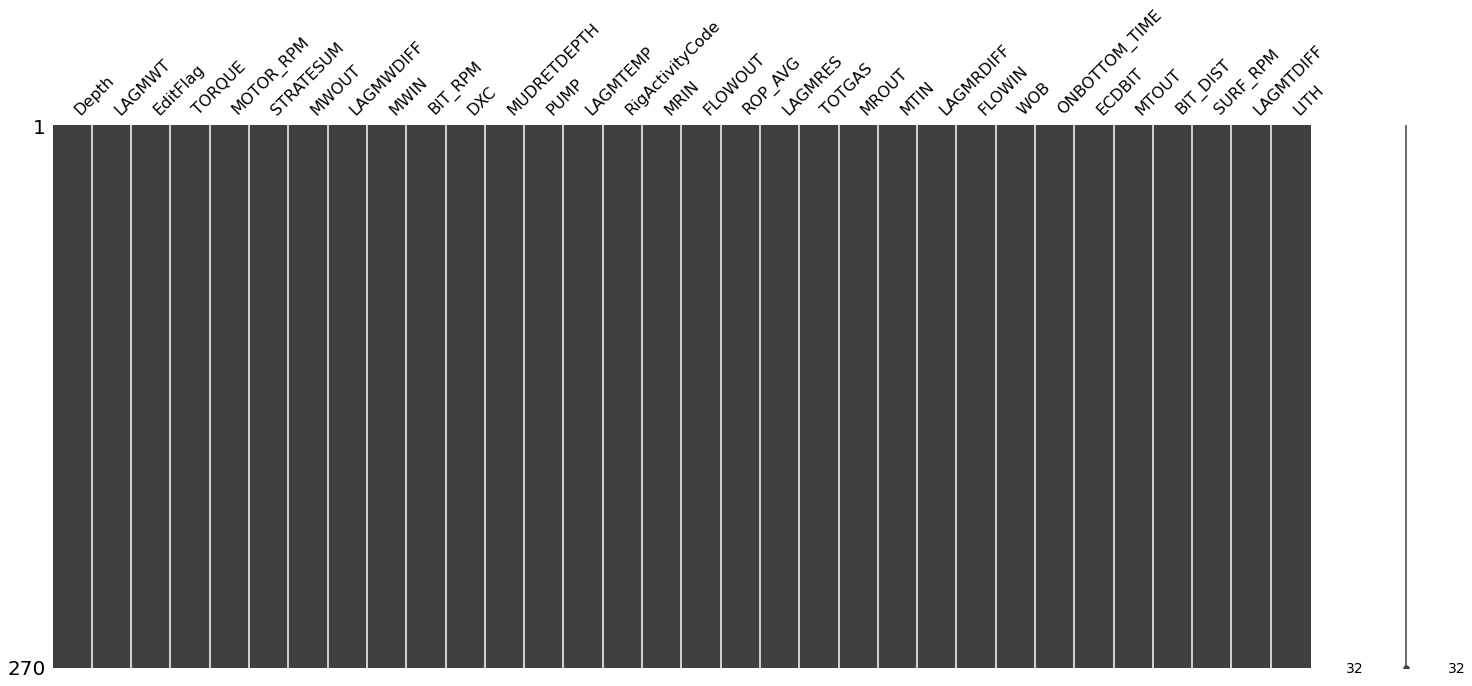

In [5]:
# Check missing values in data
msno.matrix(df);

In [6]:
df.LITH.value_counts()

sandstone    219
marl          30
claystone     17
dolomite       3
limestone      1
Name: LITH, dtype: int64

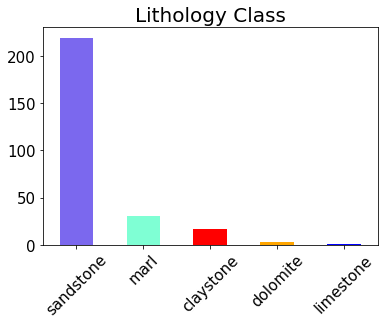

In [7]:
# df.LITH.value_counts().plot(kind='pie', figsize=(7,7), autopct='%1.1f%%', fontsize=20)
df.LITH.value_counts().plot(kind='bar', fontsize=15, rot=45,
                            color=['mediumslateblue', 'aquamarine', 'red', 'orange', 'blue'])
plt.title('Lithology Class', size=20);

In [8]:
# Remove limestone and dolomite
df = df[(df.LITH!='limestone') & (df.LITH!='dolomite')]

df.head()

,Depth,LAGMWT,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,BIT_RPM,DXC,MUDRETDEPTH,PUMP,LAGMTEMP,RigActivityCode,MRIN,FLOWOUT,ROP_AVG,LAGMRES,TOTGAS,MROUT,MTIN,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF,LITH
0,3300.0,1280.0000,0.0,3768.1461,0.0,0.300773,1280.0000,0.000000,1280.0000,0.267094,0.987674,3299.0000,3112134.6,0.0,111.0,0.0,0.016037,0.005075,0.0,0.000108,0.0,0.0,0.0,0.006662,-19762.743,194.0,1293.6605,0.0,0.995211,0.267094,0.0,claystone
1,3305.0,1280.0000,0.0,20991.5430,0.0,1.674558,1306.2254,26.225434,1306.2254,1.314148,0.987674,3301.7245,17932214.0,0.0,111.0,0.0,0.038981,0.004088,0.0,0.000183,0.0,0.0,0.0,0.037091,26217.864,1617.0,1360.8740,0.0,5.995622,1.314720,0.0,marl
2,3310.0,1315.2258,0.0,22610.3830,0.0,1.766764,1320.0146,4.788793,1320.0146,1.328706,0.987674,3301.7245,20878002.0,0.0,111.0,0.0,0.041079,0.005159,0.0,0.000176,0.0,0.0,0.0,0.039134,83492.293,2435.0,1382.0713,0.0,10.997926,1.328674,0.0,marl
3,3315.0,1320.0008,0.0,24296.9810,0.0,1.768285,1320.0000,-0.000815,1320.0000,1.420887,0.987674,3302.8926,20728354.0,0.0,111.0,0.0,0.041359,0.005971,0.0,0.000188,0.0,0.0,0.0,0.039168,97087.882,3442.0,1381.7741,0.0,15.997564,1.420116,0.0,claystone
4,3320.0,1320.0000,0.0,24931.3130,0.0,1.783305,1320.0000,-0.000002,1320.0000,1.595948,0.987674,3306.1559,20553813.0,0.0,111.0,0.0,0.043607,0.005419,0.0,0.000276,0.0,0.0,0.0,0.039500,54793.206,4333.0,1381.5933,0.0,20.990649,1.593931,0.0,claystone


## Erroneous features

In [9]:
df.describe()

,Depth,LAGMWT,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,BIT_RPM,DXC,MUDRETDEPTH,PUMP,LAGMTEMP,RigActivityCode,MRIN,FLOWOUT,ROP_AVG,LAGMRES,TOTGAS,MROUT,MTIN,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF
count,266.000000,266.000000,266.0,266.000000,266.0,266.000000,266.000000,266.000000,266.000000,266.000000,2.660000e+02,266.000000,2.660000e+02,266.000000,266.0,266.0,266.000000,266.000000,266.0,266.000000,266.0,266.000000,266.0,266.000000,2.660000e+02,266.000000,266.000000,266.0,266.000000,266.000000,266.000000
mean,3977.631579,1319.681303,0.0,23252.763853,0.0,1.771667,1319.797895,0.116592,1319.797895,2.259363,9.876741e-01,3958.437628,2.176950e+07,286.157987,111.0,0.0,0.040395,0.007867,0.0,0.013517,0.0,289.996326,0.0,0.039242,5.746018e+04,94687.759398,1426.459935,0.0,678.803872,2.261777,-286.157987
std,389.585207,3.472684,0.0,3103.327062,0.0,0.168429,2.590895,1.633482,2.590895,0.413233,4.115569e-15,388.374785,2.611370e+06,69.647782,0.0,0.0,0.002931,0.001331,0.0,0.009674,0.0,61.178029,0.0,0.003731,1.223188e+05,50116.164534,24.781933,0.0,389.451385,0.401418,69.647782
min,3300.000000,1280.000000,0.0,993.720810,0.0,0.009412,1280.000000,-0.000815,1280.000000,0.010555,9.876740e-01,3299.000000,1.396055e+06,0.000000,111.0,0.0,0.013956,0.002652,0.0,0.000108,0.0,0.000000,0.0,0.000208,-4.300360e+04,194.000000,1293.660500,0.0,0.995211,0.267094,-303.150000
25%,3646.250000,1320.000000,0.0,22053.335250,0.0,1.783333,1320.000000,0.000000,1320.000000,1.999417,9.876740e-01,3623.970050,2.093404e+07,303.150000,111.0,0.0,0.039895,0.007392,0.0,0.004739,0.0,303.150000,0.0,0.039501,3.703277e+04,55484.750000,1422.706250,0.0,347.241180,1.999537,-303.150000
50%,3977.500000,1320.000000,0.0,23320.760000,0.0,1.800000,1320.000000,0.000000,1320.000000,2.068660,9.876740e-01,3966.002700,2.185455e+07,303.150000,111.0,0.0,0.040358,0.008163,0.0,0.013176,0.0,303.150000,0.0,0.039870,4.562943e+04,96200.000000,1434.752000,0.0,678.496170,2.068851,-303.150000
75%,4313.750000,1320.000000,0.0,25198.227250,0.0,1.800000,1320.000000,0.000000,1320.000000,2.663961,9.876740e-01,4293.959125,2.321287e+07,303.150000,111.0,0.0,0.041323,0.008713,0.0,0.021548,0.0,303.150000,0.0,0.039870,5.507690e+04,136784.000000,1443.089275,0.0,1014.744300,2.663939,-303.150000
max,4645.000000,1320.000800,0.0,31208.191000,0.0,1.816672,1320.014600,26.225434,1320.014600,3.000916,9.876740e-01,4622.785100,2.547392e+07,303.150000,111.0,0.0,0.044405,0.010447,0.0,0.036226,0.0,303.150120,0.0,0.040239,1.857840e+06,181514.000000,1451.645600,0.0,1345.992300,3.000691,0.000000


In [10]:
some_erroneous_features = ['RigActivityCode', 'DXC', 'MWIN', 'LAGMTDIFF', 'WOB']
summary_stats_erroneous = df[some_erroneous_features].describe().round(2) # Suppress scientific notation

summary_stats_erroneous

,RigActivityCode,DXC,MWIN,LAGMTDIFF,WOB
count,266.0,266.00,266.00,266.00,266.00
mean,111.0,0.99,1319.80,-286.16,57460.18
std,0.0,0.00,2.59,69.65,122318.81
min,111.0,0.99,1280.00,-303.15,-43003.60
25%,111.0,0.99,1320.00,-303.15,37032.77
50%,111.0,0.99,1320.00,-303.15,45629.43
75%,111.0,0.99,1320.00,-303.15,55076.90
max,111.0,0.99,1320.01,0.00,1857840.10


count    266.000000
mean       0.116592
std        1.633482
min       -0.000815
25%        0.000000
50%        0.000000
75%        0.000000
max       26.225434
Name: LAGMWDIFF, dtype: float64
[ 0.0000000e+00  2.6225434e+01  4.7887933e+00 -8.1542028e-04
 -1.5581106e-06  2.7794590e-09  4.2088347e-12 -6.9823986e-15
  4.4488901e-22  1.2055549e-25  2.1578222e-28  7.0641917e-32
 -1.6330117e-34  7.0887803e-38  1.7966955e-40  2.4839106e-44
 -1.1446593e-47]


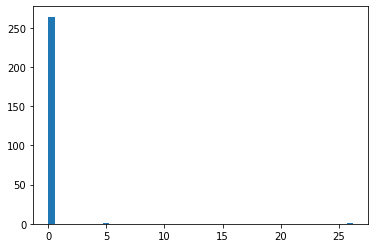

In [11]:
erroneus_feature = 'LAGMWDIFF'

print(df[erroneus_feature].describe())
print(df[erroneus_feature].unique())
plt.hist(df[erroneus_feature], bins=50)
# plt.xlim(0,0.2)
# plt.ylim(ymax=20)
plt.show()

In [12]:
# Calculate proportion of zeroes in each feature
for col in df.columns:
  sum_zeros = (df[col]==0).sum()
  pct_zeros = sum_zeros / len(df) * 100
  print(f'{col}: {pct_zeros:.0f}%')

Depth: 0%
LAGMWT: 0%
EditFlag: 100%
TORQUE: 0%
MOTOR_RPM: 100%
STRATESUM: 0%
MWOUT: 0%
LAGMWDIFF: 81%
MWIN: 0%
BIT_RPM: 0%
DXC: 0%
MUDRETDEPTH: 0%
PUMP: 0%
LAGMTEMP: 5%
RigActivityCode: 0%
MRIN: 100%
FLOWOUT: 0%
ROP_AVG: 0%
LAGMRES: 100%
TOTGAS: 0%
MROUT: 100%
MTIN: 4%
LAGMRDIFF: 100%
FLOWIN: 0%
WOB: 0%
ONBOTTOM_TIME: 0%
ECDBIT: 0%
MTOUT: 100%
BIT_DIST: 0%
SURF_RPM: 0%
LAGMTDIFF: 5%
LITH: 0%


Erroneus features:

* MOTOR_RPM, MTOUT, MROUT, MRIN, LAGMRES, LAGMRDIFF, and EditFlag have all zeros 
* DXC and RigActivityCode have all same values, 0.98767 and 111, respectively
* MWIN, LAGMTEMP, MTIN, MWOUT, LAGMTDIFF, and LAGMWT have all percentiles and maximum value similar
* LAGMWDIFF has 80% zero values and very large maximum value (outlier)
* WOB has negative minimum value (which can't be true) and very large maximum value (outlier)

All these erroneus features won't be used in our prediction, except for WOB, we can remove the outliers and still use it. 

In [13]:
erroneous_feature = ['MOTOR_RPM', 'MTOUT', 'MROUT', 'MRIN', 'LAGMRES', 'LAGMRDIFF', 
                    'EditFlag', 'DXC', 'RigActivityCode', 'LAGMWT', 'MWIN', 
                    'LAGMTEMP', 'MTIN', 'MWOUT', 'LAGMTDIFF', 'LAGMWDIFF']
df = df.drop(erroneous_feature, axis=1)

# Manually remove outliers from WOB
df = df[(df.WOB<1e6) & (df.WOB>0)].reset_index(drop=True)

df.head()

,Depth,TORQUE,STRATESUM,BIT_RPM,MUDRETDEPTH,PUMP,FLOWOUT,ROP_AVG,TOTGAS,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,BIT_DIST,SURF_RPM,LITH
0,3305.0,20991.543,1.674558,1.314148,3301.7245,17932214.0,0.038981,0.004088,0.000183,0.037091,26217.864,1617.0,1360.8740,5.995622,1.314720,marl
1,3310.0,22610.383,1.766764,1.328706,3301.7245,20878002.0,0.041079,0.005159,0.000176,0.039134,83492.293,2435.0,1382.0713,10.997926,1.328674,marl
2,3315.0,24296.981,1.768285,1.420887,3302.8926,20728354.0,0.041359,0.005971,0.000188,0.039168,97087.882,3442.0,1381.7741,15.997564,1.420116,claystone
3,3320.0,24931.313,1.783305,1.595948,3306.1559,20553813.0,0.043607,0.005419,0.000276,0.039500,54793.206,4333.0,1381.5933,20.990649,1.593931,claystone
4,3325.0,24330.264,1.783333,1.653237,3311.3763,20492430.0,0.043191,0.005435,0.000253,0.039501,50301.579,5255.0,1381.1635,25.996929,1.653262,marl


## EDA

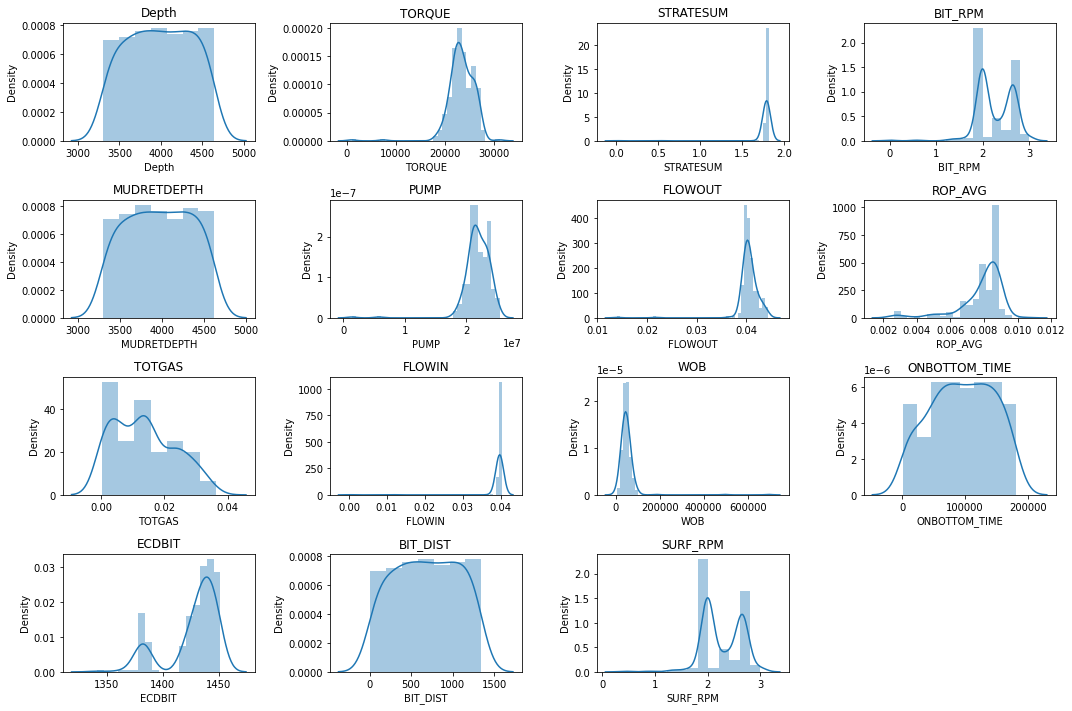

In [14]:
features = df.columns[:-1]

plt.figure(figsize=(15,12))
for i in range(len(features)):
  plt.subplot(5,4,i+1)
  sns.distplot(df[features[i]], kde=True)
  plt.title(features[i])

plt.tight_layout()

In [15]:
def corr_heatmap(df):
  # Generate a mask for the upper triangle
  mask = np.zeros_like(df.corr(method = 'spearman') , dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  # Generate a custom diverging colormap
  cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)
  cmap = 'PRGn'
  cmap = 'plasma'

  # Draw the heatmap with the mask and correct aspect ratio
  plt.figure(figsize=(12,10))
  sns.heatmap(df.corr(method = 'spearman') ,annot=True,  mask=mask, cmap=cmap, 
              vmin=0, vmax=1, square=True)

  plt.show()

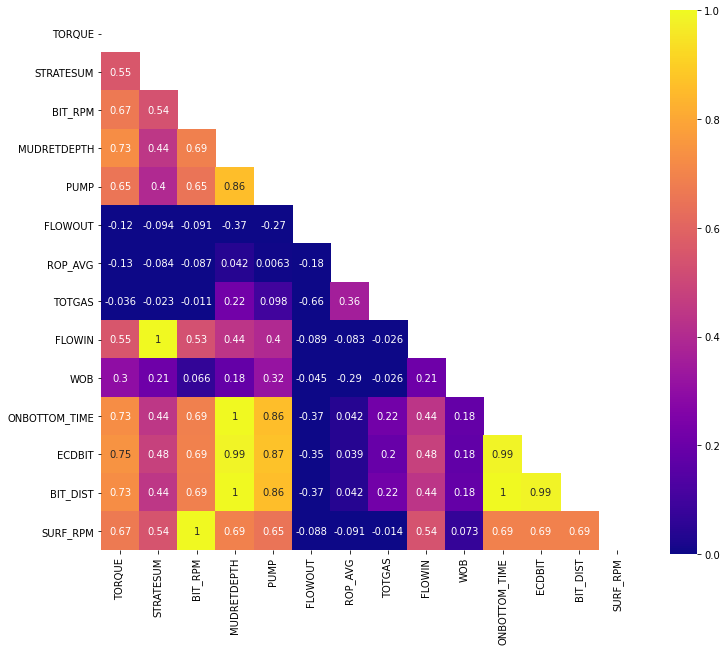

In [16]:
# All features without depth
no_depth = df.columns[1:]

# Plot correlation heatmap
corr_heatmap(df[no_depth])

In [17]:
# Remove correlated features
correlated_feature = ['MUDRETDEPTH', 'BIT_DIST', 'ONBOTTOM_TIME', 'SURF_RPM', 'FLOWIN']
df = df.drop(correlated_feature, axis=1)

df.head()

,Depth,TORQUE,STRATESUM,BIT_RPM,PUMP,FLOWOUT,ROP_AVG,TOTGAS,WOB,ECDBIT,LITH
0,3305.0,20991.543,1.674558,1.314148,17932214.0,0.038981,0.004088,0.000183,26217.864,1360.8740,marl
1,3310.0,22610.383,1.766764,1.328706,20878002.0,0.041079,0.005159,0.000176,83492.293,1382.0713,marl
2,3315.0,24296.981,1.768285,1.420887,20728354.0,0.041359,0.005971,0.000188,97087.882,1381.7741,claystone
3,3320.0,24931.313,1.783305,1.595948,20553813.0,0.043607,0.005419,0.000276,54793.206,1381.5933,claystone
4,3325.0,24330.264,1.783333,1.653237,20492430.0,0.043191,0.005435,0.000253,50301.579,1381.1635,marl


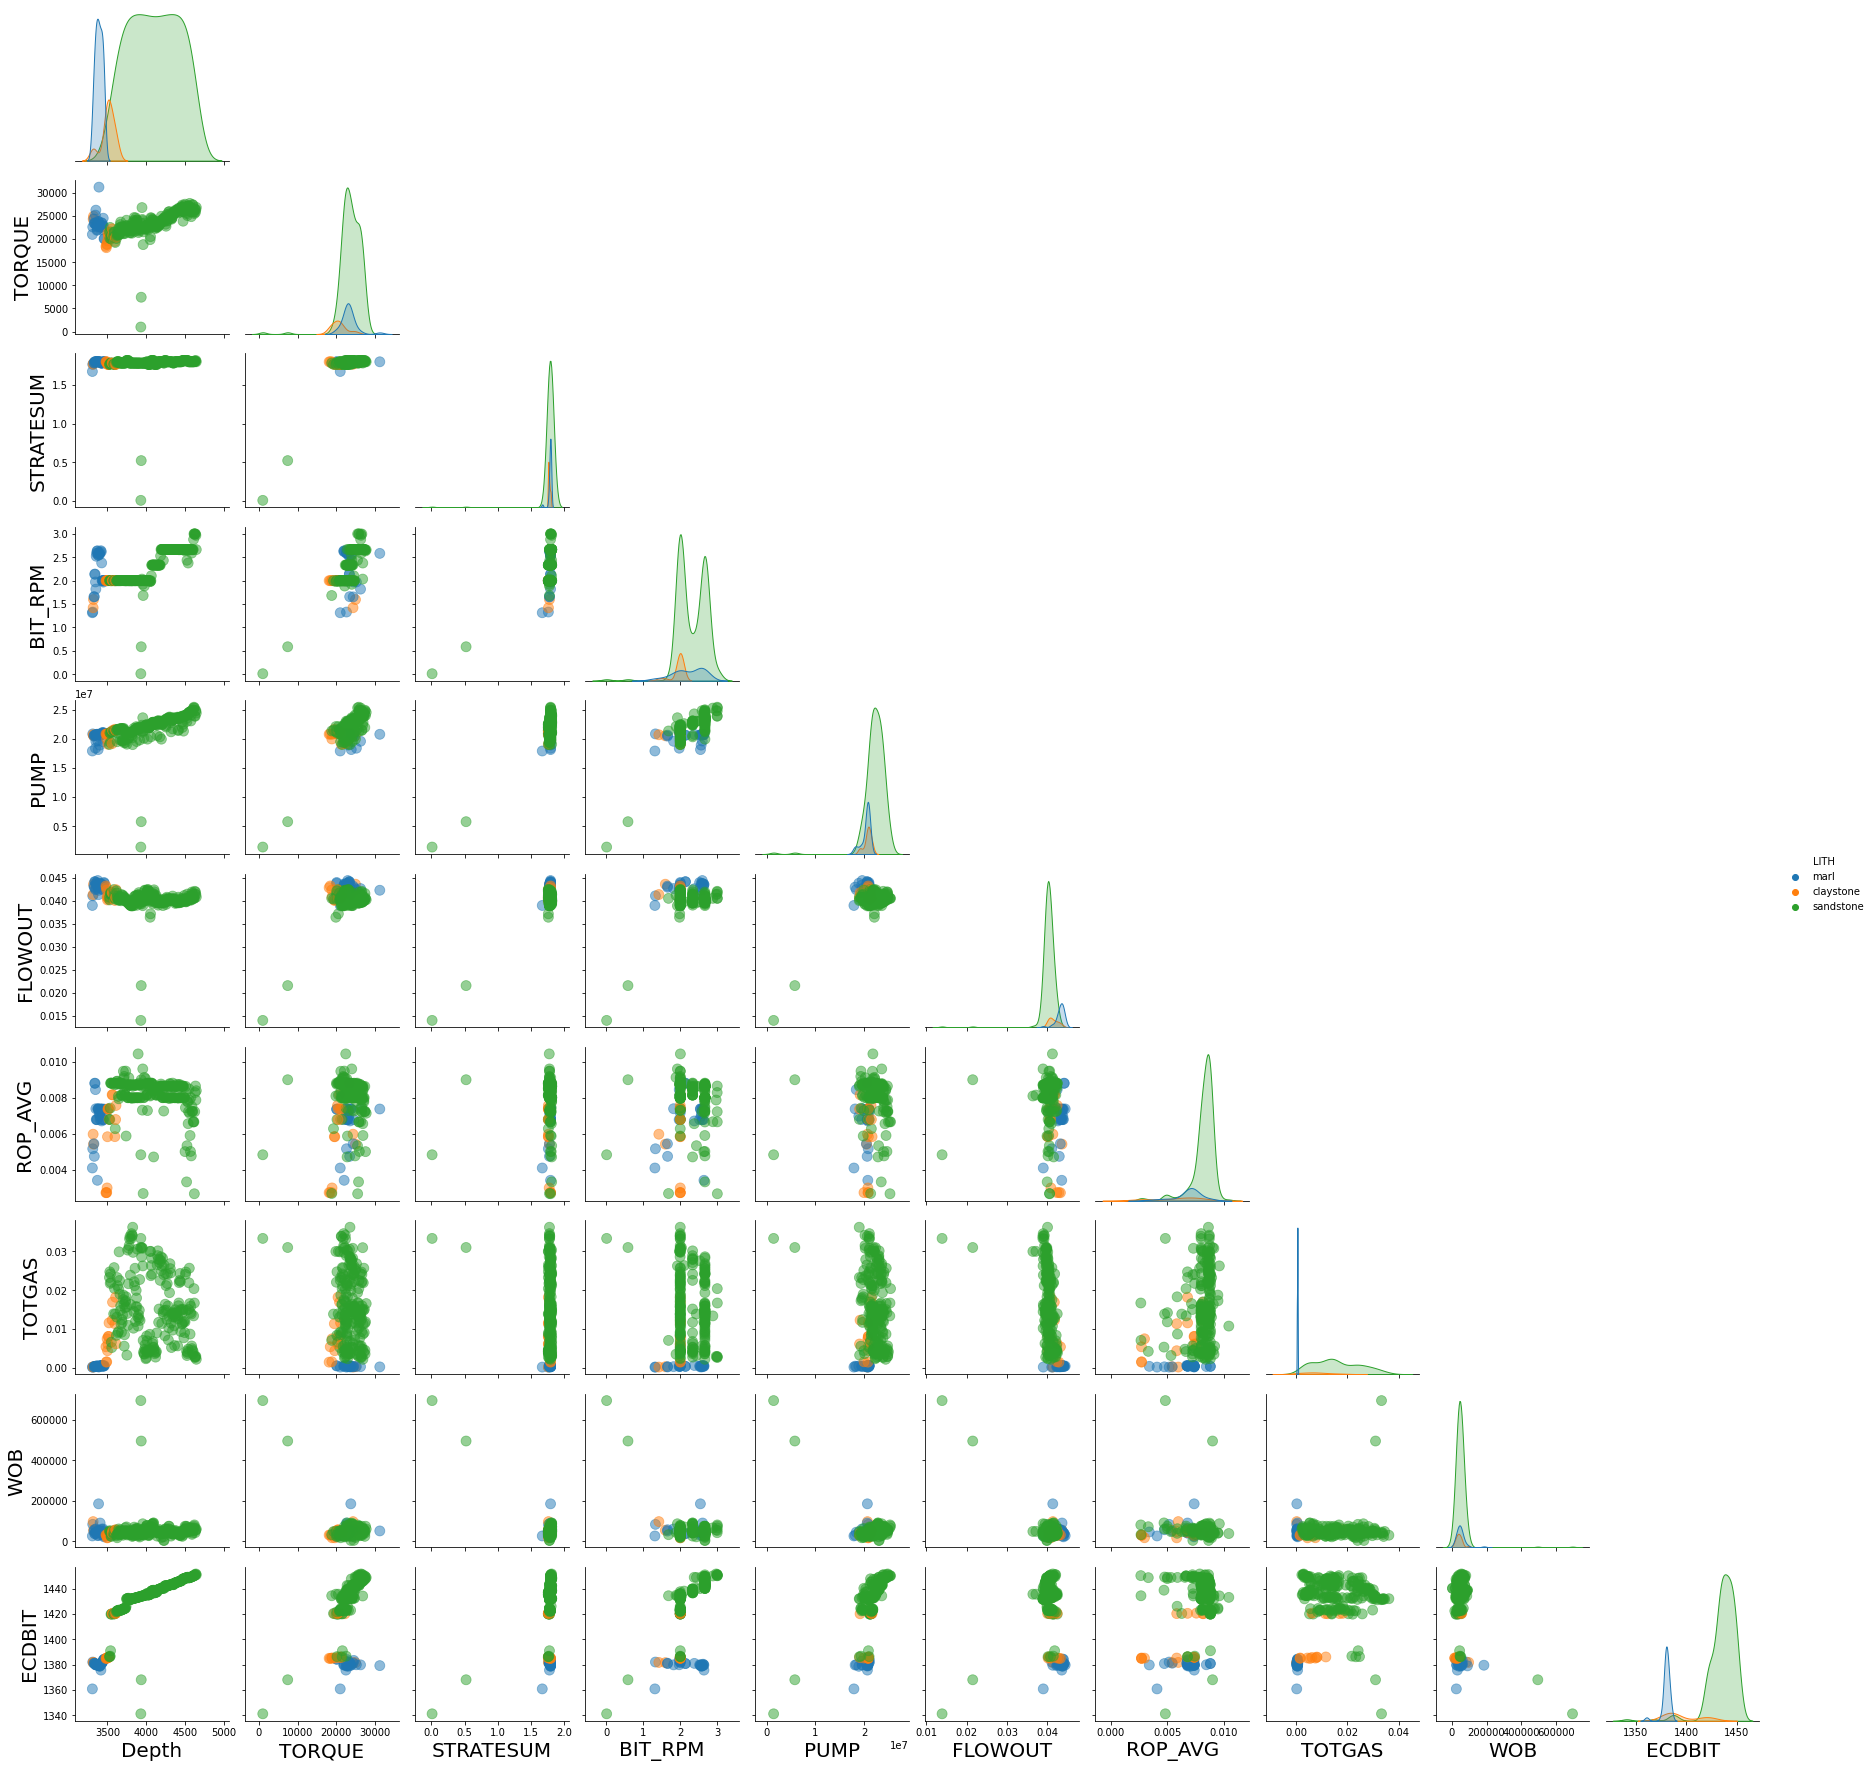

In [18]:
# Plot pairplot
plt.rcParams["axes.labelsize"] = 20
g = sns.pairplot(df, hue='LITH', corner=True,
                 plot_kws = {'alpha': 0.5, 's': 100, 'edgecolor':None})

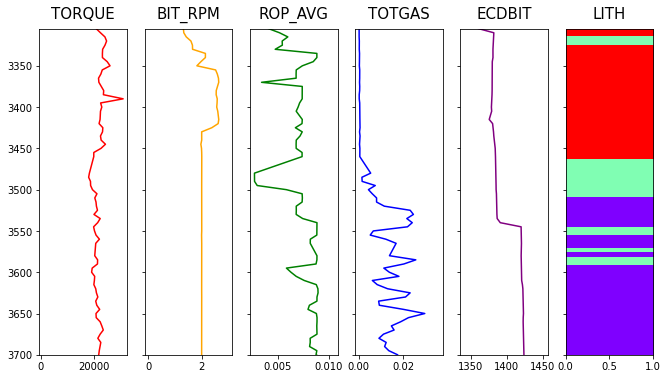

In [21]:
# Log display
rows, cols = 1, 6
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(11,6), sharey=True)
features = ['TORQUE', 'BIT_RPM', 'ROP_AVG', 'TOTGAS', 'ECDBIT']
colors = ['red', 'orange', 'green', 'blue', 'purple']

# Encode lithology
lith = df.LITH.values
lith_code = []
for i in range(len(lith)):
  if lith[i]=='sandstone':
    code = 1
  if lith[i]=='claystone':
    code = 2
  if lith[i]=='marl':
    code = 3
  lith_code.append(code)
F = np.vstack((lith_code, lith_code)).T

for i in range(cols):
    if i < cols-1:
        ax[i].plot(df[features[i]], df.Depth, color=colors[i])
        ax[i].set_ylim(max(df.Depth), min(df.Depth))
        ax[i].set_title(features[i], size=15, pad=10)
    elif i==cols-1:
        ax[i].imshow(F, aspect='auto', extent=[0,1,max(df.Depth), min(df.Depth)], cmap='rainbow')
        ax[i].set_title('LITH', size=15, pad=10)

plt.ylim(ymin=3700);

## Train-test split, oversampling with SMOTE, cross-validation, then prediction

In [ ]:
# Drop depth column 

# Separate feature and target
X, y = df.iloc[:,1:-1], df['LITH']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.30)
# Define oversampling
over = SMOTE(k_neighbors=4)

# Define model
model = AdaBoostClassifier()

# Define normalization
norm = StandardScaler()

# Put into pipeline
steps = [('norm', norm), ('o', over), ('model', model)]
pipe = Pipeline(steps=steps)

scoring = ['accuracy', 'precision_macro', 'recall_macro']
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores_pipe = cross_validate(pipe, X_train, y_train, 
                            scoring=scoring, cv=cv, n_jobs=-1)

# Oversampling test data
over = SMOTE(k_neighbors=4)
X_test, y_test = over.fit_resample(X_test, y_test)

In [ ]:
# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores_pipe['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_pipe['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_pipe['test_recall_macro']))

Mean Accuracy: 0.9672
Mean Precision: 0.8538
Mean Recall: 0.8893


In [ ]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

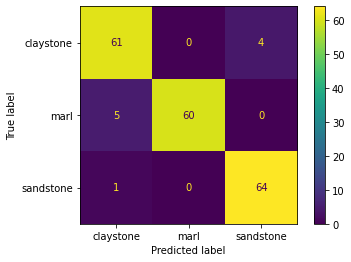

In [ ]:
plot_confusion_matrix(pipe, X_test, y_test, 
                      values_format = '.5g') # .5g to suppress scientific notation
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   claystone       0.91      0.94      0.92        65
        marl       1.00      0.92      0.96        65
   sandstone       0.94      0.98      0.96        65

    accuracy                           0.95       195
   macro avg       0.95      0.95      0.95       195
weighted avg       0.95      0.95      0.95       195



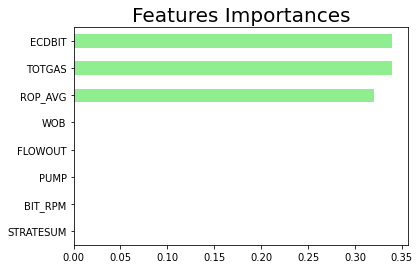

In [ ]:
feature_importance = pipe.steps[2][1].feature_importances_

# Create a pd.Series of features importances
importances = pd.Series(data=feature_importance,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances', size=20)
plt.show()

In [ ]:
# Generate class membership probabilities
y_pred_probs = pipe.predict_proba(X_test)

# Example prediction for observation no. 10
no_obs = 9
classes = ['claystone', 'marl', 'sandstone']
for i in range(len(classes)):
  print(f'{classes[i]}: {y_pred_probs[no_obs-1][i]:.3f}')

claystone: 0.675
marl: 0.325
sandstone: 0.000


In [ ]:
roc_auc_score(y_test, y_pred_probs, average="weighted", multi_class="ovr")

0.9747928994082842